In [48]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.utils import shuffle

In [49]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model history")
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.legend(["train_loss", "val_loss", "train", "val"], loc="upper left")
    plt.show()

In [50]:
x_train, y_train = np.load("x_train50x50.npz")['arr_0'], np.load("y_train50x50.npz")['arr_0']
x_test, y_test = np.load("test_x_train50x50.npz")['arr_0'], np.load("test_y_train50x50.npz")['arr_0']
x_train, y_train = shuffle(x_train, y_train)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9200, 50, 50, 3), (9200, 5), (817, 50, 50, 3), (817, 5))

In [51]:
# classifications = ['cpp_go_left', 'cpp_go_right', 'cpp_notgo', 'cpp_onlygo', 'cpp_onlyleft', 'cpp_onlyright', 'cpp_stop_line', 'cpp_stop_pic', 'notleft_sign', 'notright_pic', 'notstop_pic']classifications = ['no_right', 'no_stop', 'only_right', 'stop_line', 'stop_pic']
classifications = ['no_right', 'no_stop', 'only_right', 'stop_line', 'stop_pic']
len(classifications)

5

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


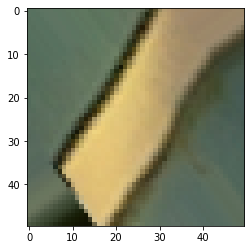

stop_line


In [52]:
datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    featurewise_center=True,
    featurewise_std_normalization=True,
    channel_shift_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=90,
)

data = datagen.flow(x_train, y_train, batch_size=64)

n = 2
plt.imshow(data[n][0][0])
plt.show()
print(classifications[np.where(data[n][1][0]==1)[0][0]])

In [53]:
model = None
model = Sequential([
    layers.Input(shape=(50, 50, 3)),
    # layers.BatchNormalization(),
    
    layers.Conv2D(1024, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='sigmoid'),
    layers.Dense(256, activation='sigmoid'),
    layers.Dense(len(classifications), activation='softmax'),
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 50, 1024)      28672     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 1024)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 64)        262208    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 512)              

Epoch 1/5


/var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/ipykernel_76386/2407853362.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(data,  epochs=5, verbose=1,
2022-08-28 16:56:23.292853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.6930

2022-08-28 16:57:27.943372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 67s 455ms/step - loss: 0.2546 - accuracy: 0.6930 - val_loss: 0.3611 - val_accuracy: 0.5373
Epoch 2/5
144/144 [==============================] - 69s 477ms/step - loss: 0.1027 - accuracy: 0.8952 - val_loss: 0.1456 - val_accuracy: 0.8237
Epoch 3/5
144/144 [==============================] - 80s 544ms/step - loss: 0.0518 - accuracy: 0.9550 - val_loss: 0.2178 - val_accuracy: 0.7944
Epoch 4/5
144/144 [==============================] - 105s 724ms/step - loss: 0.0367 - accuracy: 0.9688 - val_loss: 0.0604 - val_accuracy: 0.9449
Epoch 5/5
26/26 [==============================] - 5s 189ms/step - loss: 0.1090 - accuracy: 0.8923


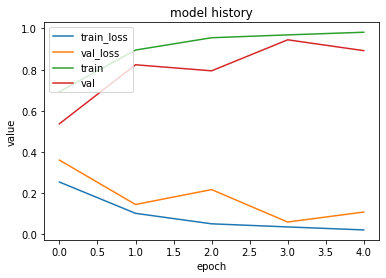

Test:
Loss: 0.10900748521089554
Accuracy: 0.892288863658905


In [54]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
epochs= 5
hist = model.fit_generator(data, epochs=epochs, verbose=1,
                           validation_data=(x_test, y_test))
loss, accuracy = model.evaluate(x_test, y_test)
plot_hist(hist)
print('Test:')
print('Loss: %s\nAccuracy: %s' % (loss, accuracy))


In [56]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(f"model_{epochs}.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmpdllwmt1u/assets


INFO:tensorflow:Assets written to: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmpdllwmt1u/assets
2022-08-28 17:04:44.891326: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-28 17:04:44.891543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-08-28 17:04:44.892859: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmpdllwmt1u
2022-08-28 17:04:44.895314: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-28 17:04:44.895323: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/tz/3mdp4k9x3k94jf1r3s37rps80000gn/T/tmpdllwmt1u
2022-08-28 17:04:44.901019: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-08-28 17:04:45.016592: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

In [57]:
epochs = 5
with open(f"model_{epochs}.tflite", 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

print(interpreter.get_input_details()[0])

{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 50, 50,  3], dtype=int32), 'shape_signature': array([-1, 50, 50,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [58]:
correct = 0
for x, y in zip(x_test, y_test):
  interpreter.set_tensor(input_index, np.array([x.astype(np.float32)]))
  interpreter.invoke()
  output = interpreter.get_tensor(output_index)
  answer = np.argmax(y)
  if np.argmax(output) == answer:
    correct += 1
  else:
    continue
    print(classifications[np.argmax(output)], output)
    plt.imshow(x)
    plt.show()

print(correct / len(x_test))

0.8922888616891065
